In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
#%pip install elephas

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

2023-04-07 20:03:52.052089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 20:03:52.180007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-07 20:03:52.180029: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not 

In [4]:
# Load and preprocess the data
station = 235
data = get_specific_station_data(station,'4w',1800)

# Scale the precipitation data
scaler = MinMaxScaler()
data["precipitation"] = scaler.fit_transform(data[["precipitation"]])

# Prepare the input and output for the RNN model
def prepare_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : (i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = prepare_data(data["precipitation"].values, window_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input to be 3D (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Create the RNN model with GRU units
def create_model():
    model = Sequential()
    model.add(GRU(units=50, activation="relu", input_shape=(window_size, 1), return_sequences=True))
    model.add(GRU(units=50, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


# Train the model using Keras
model = create_model()
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_split=0.1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print("Train loss:", train_loss)
print("Test loss:", test_loss)

2023-04-07 20:03:57.648823: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-07 20:03:57.648870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rmsryu-vm): /proc/driver/nvidia/version does not exist
2023-04-07 20:03:57.649327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
28/28 - 2s - loss: 0.0317 - val_loss: 0.0161 - 2s/epoch - 80ms/step
Epoch 2/20
28/28 - 0s - loss: 0.0197 - val_loss: 0.0159 - 220ms/epoch - 8ms/step
Epoch 3/20
28/28 - 0s - loss: 0.0195 - val_loss: 0.0158 - 221ms/epoch - 8ms/step
Epoch 4/20
28/28 - 0s - loss: 0.0194 - val_loss: 0.0157 - 222ms/epoch - 8ms/step
Epoch 5/20
28/28 - 0s - loss: 0.0192 - val_loss: 0.0159 - 222ms/epoch - 8ms/step
Epoch 6/20
28/28 - 0s - loss: 0.0193 - val_loss: 0.0159 - 229ms/epoch - 8ms/step
Epoch 7/20
28/28 - 0s - loss: 0.0192 - val_loss: 0.0156 - 218ms/epoch - 8ms/step
Epoch 8/20
28/28 - 0s - loss: 0.0191 - val_loss: 0.0155 - 212ms/epoch - 8ms/step
Epoch 9/20
28/28 - 0s - loss: 0.0190 - val_loss: 0.0154 - 221ms/epoch - 8ms/step
Epoch 10/20
28/28 - 0s - loss: 0.0190 - val_loss: 0.0156 - 223ms/epoch - 8ms/step
Epoch 11/20
28/28 - 0s - loss: 0.0188 - val_loss: 0.0155 - 211ms/epoch - 8ms/step
Epoch 12/20
28/28 - 0s - loss: 0.0187 - val_loss: 0.0161 - 223ms/epoch - 8ms/step
Epoch 13/20
28/28 - 0s - lo

In [5]:
# Generate predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

8/8 [==============================] - 0s 3ms/step
RMSE: 0.13962936
MAE: 0.10947232


RMSE: 0.13962936401367188


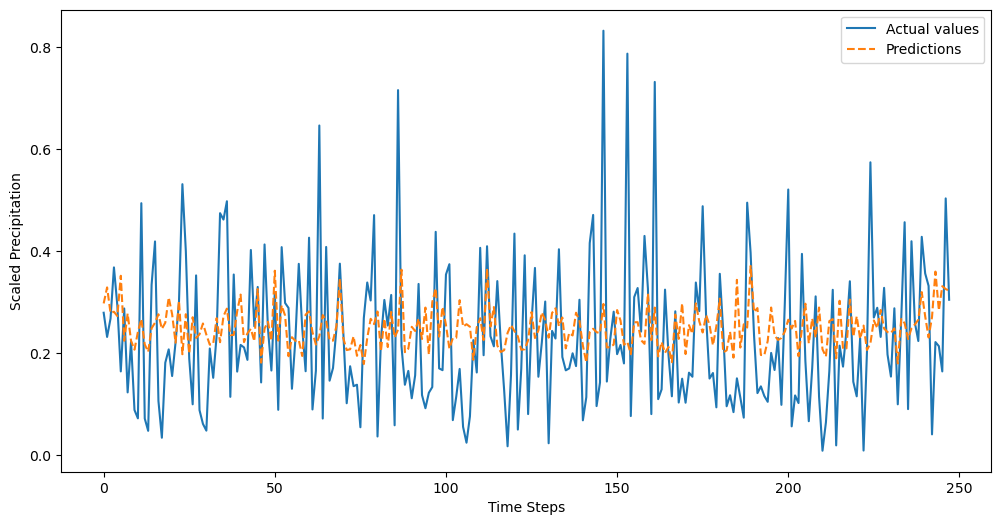

In [6]:
import matplotlib.pyplot as plt
print(f"RMSE: {rmse}")
plt.figure(figsize=(12, 6))
plt.plot(y_test, label=f'Actual values')
plt.plot(y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()